### Breakdown of extra classes
- LeNet: Main code that implements a normal CNN(LeNet)
- Data: Holds DiffractionDataset, which is a subclass of the PyTorch 'Dataset' class, basically just turns our tensors(data) into useable values that we can throw into models and do distributed training

In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas
from collections import OrderedDict
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

import os
from datetime import datetime
import math

#Our Own Created Classes
from LeNet import LeNet
from Data import DiffractionDataset

# Step 1: Load and Analyze Data

In [9]:
#might have to do /content/ if used colab
TrainingData = torch.load("/content/100k_COD_TestTensor.pt") #dict with diffraction patterns and space group

### Load and AnalyzeTraining Data

In [11]:
data = TrainingData['X']
labels = TrainingData['Y']
mapping = torch.load("/content/mapping.pt") #our data is in numbers, this maps numbers to actual bravais lattices


In [12]:
labels.shape #number of entires for train/val

torch.Size([1959])

The next module shows the distribution of every bravais lattice, and shows the sad reality of scientific data -- a label imbalance

Text(0.5, 1.0, 'Distribution of labels')

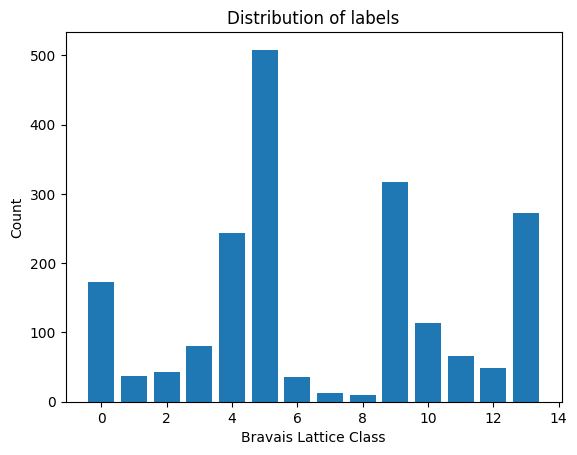

In [13]:
unique_values, counts = torch.unique(labels, return_counts=True)
plt.bar(unique_values.numpy(), counts.numpy())
plt.xlabel("Bravais Lattice Class")
plt.ylabel("Count")
plt.title("Distribution of labels")

### Create Validation Set
- The purpose of a validation set is used to analyze our model's preformance on data that it hasnt trained on
- We use the test set as a "final" metric

In [14]:
data_np = data.numpy()
labels_np = labels.numpy()
nptrainx, npvalx, nptrainy, npvaly = train_test_split( data_np, labels_np, test_size=0.05, random_state=42)

validation_data = torch.from_numpy(npvalx)
validation_labels = torch.from_numpy(npvaly)
train_data = torch.from_numpy(nptrainx)
train_labels = torch.from_numpy(nptrainy)
print("Train Shape:", train_labels.shape)
print("Val Shape:", validation_labels.shape)

Train Shape: torch.Size([1861])
Val Shape: torch.Size([98])


In [15]:
train_data.shape

torch.Size([1861, 3041])

# Step 2: Train the Models
Define Hyperparmeters, put the model together, train it, and then repeat until the model's preformance looks good


In [20]:
learning_rate = 0.5e-3
epochs = 15
batch_size = 50
input_size = 3041
num_classes = 14

In [17]:
model = LeNet(input_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-5)
crossentropy_loss_function = torch.nn.CrossEntropyLoss()

In [18]:
train_dataset = DiffractionDataset(num_classes, 1e-3, train_data, labels=train_labels, unsupervised=False, categorical='Bravais Lattice')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

validation_dataset = DiffractionDataset(num_classes, 1e-3, validation_data, labels = validation_labels, unsupervised=False, categorical='Bravais Lattice')
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)


Attempting to load data
Attempting to load data


In [21]:
start = datetime.now()
for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    # Training Loop
    i = 0
    for imgs, labels in train_loader:
        i+=1
        optimizer.zero_grad()
        logits = model(imgs) #compute Predictions
        loss = crossentropy_loss_function(logits, labels) #compute Loss
        loss.backward() #update Model
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean().item()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=-1) == labels).sum().item()
        total_samples += labels.size(0)
        print("[Epoch %d/%d] [%d] [Batch loss: %.2f  Batch Acc: %d%%]"% (epoch+1, epochs, i, loss.item(), 100 * acc))


    train_acc = total_correct / total_samples * 100
    print(f"Epoch {epoch+1} Training Accuracy: {train_acc:.2f}%")


    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            logits = model(imgs)
            total_correct += (logits.argmax(dim=-1) == labels).sum().item()
            total_samples += labels.size(0)

    val_acc = total_correct / total_samples * 100
    print(f"[Epoch %d/%d] [Training Loss: %d%%  Validation Loss: %d%%] " % (epoch+1, epochs, (train_acc),(val_acc)))
totalTime = datetime.now() - start
print(f"Total Train Time: {totalTime}")
torch.save({f'Model | {epochs} {batch_size} {learning_rate} | {datetime.now()}': model.state_dict(),'Optimizer | {epochs} {batch_size} {learning_rate} | {time}': optimizer.state_dict()}, os.getcwd())

[Epoch 1/15] [1] [Batch loss: 1.80  Batch Acc: 30%]
[Epoch 1/15] [2] [Batch loss: 2.10  Batch Acc: 34%]
[Epoch 1/15] [3] [Batch loss: 1.83  Batch Acc: 46%]
[Epoch 1/15] [4] [Batch loss: 1.81  Batch Acc: 41%]
[Epoch 1/15] [5] [Batch loss: 1.92  Batch Acc: 34%]
[Epoch 1/15] [6] [Batch loss: 1.94  Batch Acc: 34%]
[Epoch 1/15] [7] [Batch loss: 1.92  Batch Acc: 30%]
[Epoch 1/15] [8] [Batch loss: 1.94  Batch Acc: 31%]
[Epoch 1/15] [9] [Batch loss: 2.06  Batch Acc: 37%]
[Epoch 1/15] [10] [Batch loss: 1.76  Batch Acc: 41%]
[Epoch 1/15] [11] [Batch loss: 1.90  Batch Acc: 31%]
[Epoch 1/15] [12] [Batch loss: 1.91  Batch Acc: 28%]
[Epoch 1/15] [13] [Batch loss: 2.05  Batch Acc: 34%]
[Epoch 1/15] [14] [Batch loss: 2.06  Batch Acc: 40%]
[Epoch 1/15] [15] [Batch loss: 1.53  Batch Acc: 47%]
[Epoch 1/15] [16] [Batch loss: 1.73  Batch Acc: 41%]
[Epoch 1/15] [17] [Batch loss: 1.92  Batch Acc: 31%]
[Epoch 1/15] [18] [Batch loss: 1.98  Batch Acc: 28%]
[Epoch 1/15] [19] [Batch loss: 2.04  Batch Acc: 34%]
[E

RuntimeError: File /content cannot be opened.

# Step 3: Analyze Model Results

Now its time to grab our test tensor, and look at how our model did. While we could go back and re-train our model to get better results, its common practice in ML to not do this.

In [22]:
test = torch.load("100k_COD_TestTensor.pt")
test_dataset = DiffractionDataset(num_classes, 1e-3, test['X'], labels=test['Y'], unsupervised=False, categorical='Bravais Lattice')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
model.eval() #Prints Model (Encoder -> Convolutional Layers, Classifier -> Normal ANN)

Attempting to load data


LeNet(
  (encoder): Sequential(
    (0): Conv1d(1, 6, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(6, 16, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12112, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=14, bias=True)
  )
)

In [23]:
input_example = test_dataset[0][0].unsqueeze(0)
label_example = test_dataset[0][1]
with torch.no_grad():
    output_example = model(input_example)
    example_pred = torch.argmax(output_example, dim=1).item()  # get predicted class

In [25]:
print("Example of Input(Diffraction Pattern)")
print(input_example)

Example of Input(Diffraction Pattern)
tensor([[[0.0010, 0.0010, 0.0010,  ..., 0.1043, 0.1063, 0.1083]]])


Logits are the direct output from the model for classificatio. Whatever class maps to a certain index, the number at that index in the array represents the models "confidence" that the input maps to that class

In [26]:
print("Example of Logits")
print(output_example)

Example of Logits
tensor([[-9.9035, -3.1525, -2.8459, -0.0183,  0.2066,  1.2605, -0.3816,  0.0415,
         -1.7761,  4.0757, -1.1156, -3.1902,  0.5741,  2.3537]])


In [27]:
print(f"Numeric Class: {example_pred}")
print(f"Bravais Lattice: {mapping['Bravais Lattice'][example_pred]}")

Numeric Class: 9
Bravais Lattice: P-Orthorhombic


In [29]:
print(label_example) #Hopefully its the same

tensor(9)


### Analyze using test-set

Sample Output from model: 
tensor([[-9.9035e+00, -3.1525e+00, -2.8459e+00, -1.8327e-02,  2.0659e-01,
          1.2605e+00, -3.8159e-01,  4.1543e-02, -1.7761e+00,  4.0757e+00,
         -1.1156e+00, -3.1902e+00,  5.7413e-01,  2.3537e+00],
        [-1.8698e+01, -7.3068e+00, -3.9194e+00,  6.1686e-01,  4.0044e+00,
          5.3416e+00, -2.4571e+00,  1.2811e-01, -1.2078e+00,  3.8050e+00,
         -7.3663e-01, -1.8950e+00,  1.0530e+00,  2.9854e+00],
        [-1.4137e+01, -5.7541e+00, -3.1724e+00, -1.5136e+00,  3.7067e+00,
          4.9643e+00, -1.3513e+00,  8.1811e-02, -1.1850e+00,  3.3010e+00,
         -4.5237e-01,  1.7865e-01,  1.8334e-01,  3.2009e+00],
        [-4.3391e+00, -1.8882e+00, -1.8213e+00, -9.8778e-02, -1.8939e+00,
          3.8285e+00, -2.1399e+00, -2.0025e+00, -2.1320e-01,  1.2109e+00,
         -2.5339e-01,  1.4286e-01,  1.4060e+00, -4.8245e-01],
        [-9.4622e+00, -7.0092e+00, -2.1464e+00, -2.4875e-01,  6.7859e+00,
          2.0880e-01,  9.6260e-02, -2.7138e+00, -6.0601e-01

<Figure size 1000x800 with 0 Axes>

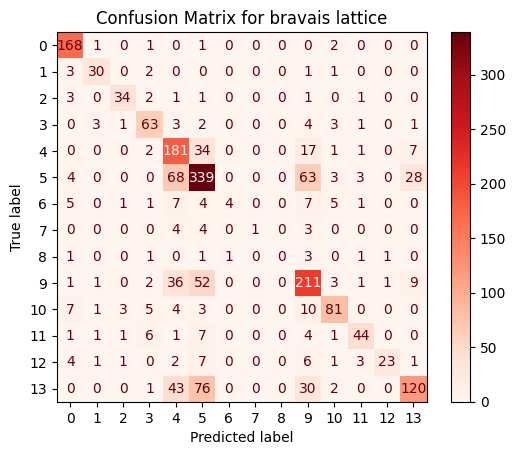

In [30]:
listofpreds = []
listoflabels = []

count = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        count+=1
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        listofpreds.extend(predictions)
        listoflabels.extend(labels)
accuracy = np.mean(np.array(listofpreds) == np.array(listoflabels))
print(f"Test Accuracy: {accuracy * 100}%")
rmse = np.sqrt(mean_squared_error(listoflabels, listofpreds))
print(f"Test Root Sqaured Mean Error(RSME): {rmse}")

conf_matrix = confusion_matrix(listoflabels, listofpreds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title("Confusion Matrix for bravais lattice")
plt.show()